# Part 1: RC Circuit simulation
In this first portion, I used a simplified equation to track the passband of the RC filter. This one, using the values **R = 1000, C = 1 uF, f = 100Hz, dt = 0.0001** will have a cutoff frequency of 159-160Hz given the equation:

fc = 1 / (2 * pi * R * C)

If you put the frequency above the cutoff, you can quite quickly see the attenuation of the signal. Putting in a frequency of 1 kHz produces an output signal less than a quarter of the amplitude of the input.

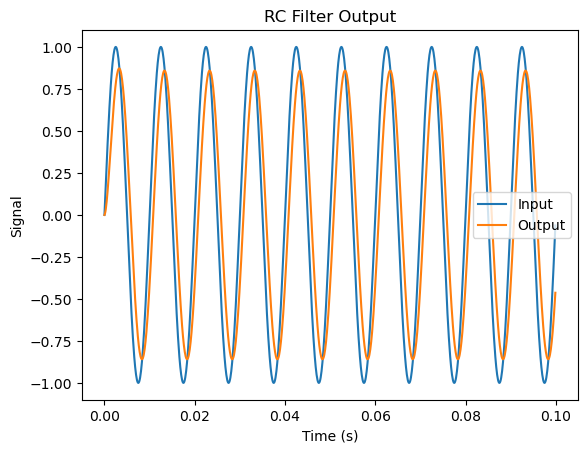

In [22]:
import numpy as np
import matplotlib.pyplot as plt

class RCFilterVerify:
    def __init__(self, R, C, dt):
        self.R = R
        self.C = C
        self.dt = dt
        self.alpha = dt / (R * C)
        self.y = 0

    def filter(self, x):
        self.y = (1 - self.alpha) * self.y + self.alpha * x
        return self.y

###--------------------------------
# Define filter parameters
R = 1000  # Resistance in ohms
C = 1e-6  # Capacitance in farads
dt = 0.0001  # Time step in seconds
f = 100  # Signal frequency in Hz
###--------------------------------

# Create RC filter object
rc_filter = RCFilterVerify(R, C, dt)

# Define simulation parameters
t_start = 0  # Start time in seconds
t_stop = 0.1  # Stop time in seconds
t = np.arange(t_start, t_stop, dt)  # Time vector

# Define input signal
x = np.sin(2 * np.pi * f * t)

# Apply filter to input signal
y = np.zeros(len(t))
for i in range(len(t)):
    y[i] = rc_filter.filter(x[i])

# Plot input and output signals
plt.plot(t, x, label='Input')
plt.plot(t, y, label='Output')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('RC Filter Output')
plt.legend()
plt.show()


# 1b Halfwave Rectifier (Two Attempts)

Both attempts use the Newton method to calculate the diode voltage at each time step. It checks for convergence by comparing the absolute difference between the current and previous estimates of the diode voltage. The loop stops when the absolute difference is less than 1e-6

The first attempt tried doing it in an OOP style like I did above, but for some reason I could not get the halfwave to appear properly. This may be because of my attempt at using the Newton-Raphson method and a lambda function incorrectly. I noticed flaws because changing the resistance or capacitance didn't change the output signal.

In the second attempt I focused on making sure my math was right and was able to get a halfwave wvaeform and see change based on the resistance and capacitance. The higher the RC constant, the higher the baseline of the output is (the closer it gets to 5V high DC output). Right now it has the values set to see the full halfwave waveform, but seeing it approach 5V DC is easy if you make the following true: **R = 2000, C = 1e6**

Having a small time constant is essential for convergence. This makes the discrete values small enough that convergence can occur.

In [23]:
class HalfwaveRectifier:
    def __init__(self, R, C, Vp, Vpk, f, dt, t_end):
        self.R = R
        self.C = C
        self.Vp = Vp
        self.Vpk = Vpk
        self.f = f
        self.dt = dt
        self.t_end = t_end
        self.time = np.arange(0, t_end+dt, dt)
        self.Vin = Vp * np.sin(2 * np.pi * f * self.time)
        self.Vout = np.zeros_like(self.Vin)
        self.Vd = np.zeros_like(self.Vin)
        
    def simulate(self):
        for i in range(1, len(self.time)):
            # Calculate the diode voltage using Newton-Raphson method
            Vd_prev = self.Vd[i-1]
            Vout_prev = self.Vout[i-1]
            Vd_next = Vd_prev
            f = lambda x: (x - Vd_prev) / (self.R * self.C) + (np.exp((x - self.Vpk) / 0.025) - 1) / (10**12) - Vout_prev / self.R
            df = lambda x: 1 / (self.R * self.C) + (1 / 0.025) * np.exp((x - self.Vpk) / 0.025) / (10**12)
            while True:
                Vd_next = Vd_prev - f(Vd_prev) / df(Vd_prev)
                if np.abs(Vd_next - Vd_prev) < 1e-6:
                    break
                Vd_prev = Vd_next
            self.Vd[i] = Vd_next
            
            # Calculate the output voltage
            if self.Vd[i] > 0:
                self.Vout[i] = self.Vd[i]
            else:
                self.Vout[i] = 0
                
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
        ax1.plot(self.time, self.Vin, label='Input')
        ax1.plot(self.time, self.Vout, label='Output')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Voltage (V)')
        ax1.legend()
        ax2.plot(self.time, self.Vd, label='Diode')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Voltage (V)')
        ax2.legend()
        plt.show()

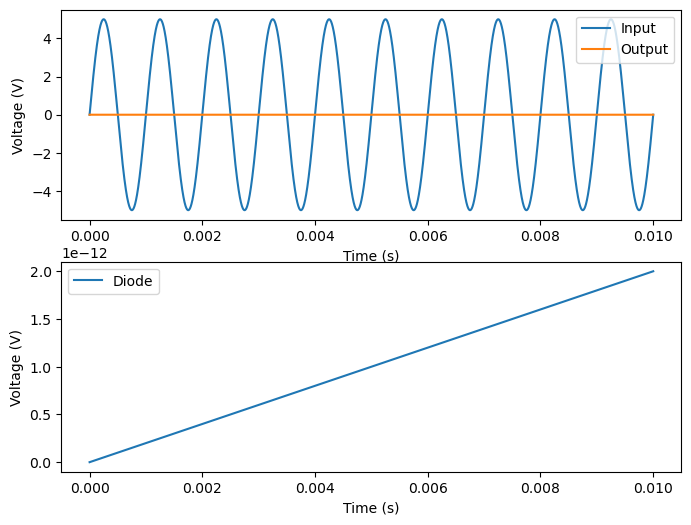

In [24]:
# halfwave circuit simulation
R = 2000  # ohms
C = 1e-7 # farads
Vpk = 0.7   # Volts
f = 1000   # Hz
dt = 1e-6   # Seconds
t_end = 0.01 # Seconds

halfwave = HalfwaveRectifier(R, C, Vp, Vpk, f, dt, t_end)
halfwave.simulate()
halfwave.plot()


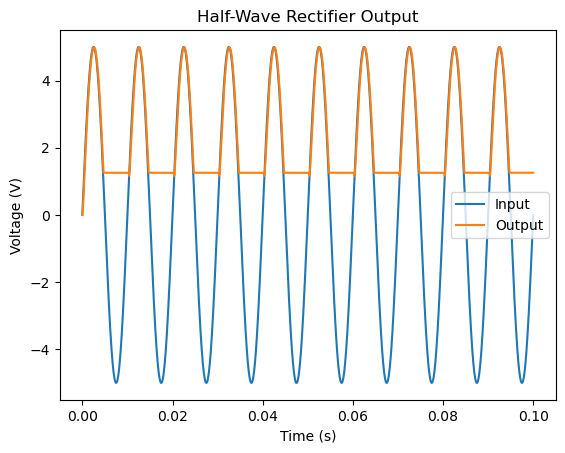

DC component of output voltage: 2.2633208093105734


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Circuit parameters
R = 1000
C = 1e-7
Vp = 5
f = 100

# Simulation parameters
dt = 1e-6
t_max = 0.1

# Calculate time constant
tau = R * C

# Generate input waveform
t = np.arange(0, t_max, dt)
V_in = Vp * np.sin(2*np.pi*f*t)

# Initialize output voltage and diode voltage
V_out = np.zeros_like(V_in)
V_d = np.zeros_like(V_in)

# Simulation loop
for i in range(1, len(t)):
    # Calculate the diode voltage
    V_d[i] = V_in[i] - V_out[i-1]
    
    # Check for convergence of the diode voltage
    for j in range(10):
        V_d_prev = V_d[i]
        V_d[i] = V_in[i] - V_out[i-1] + (Vp / np.pi) * np.sin(2*np.pi*f*t[i])
        if abs(V_d[i] - V_d_prev) < 1e-6:
            break
    
    # Update the output voltage
    V_out[i] = V_out[i-1] + dt * (V_in[i] - V_out[i-1]) / tau * (V_d[i] >= 0)

# Calculate the DC component of the output voltage
V_dc = np.mean(V_out)

# Plot the input and output waveforms
plt.plot(t, V_in, label='Input')
plt.plot(t, V_out, label='Output')
plt.title('Half-Wave Rectifier Output')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

print('DC component of output voltage:', V_dc)
